In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import datetime,timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install arch

import arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.3 MB/s eta 0:00:00


In [ ]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.Ticker(ticker)
    stock_df = stock_data.history(period = "1d", start=start_date, end=end_date)
    return stock_df

In [ ]:
df = get_stock_data("ASIANPAINT.NS", datetime(2010,1,1),datetime(2025,1,20))

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00+05:30,157.839016,158.623363,156.869592,157.631912,80350,0.0,0.0
2010-01-05 00:00:00+05:30,158.455923,159.068413,157.310244,158.129837,849100,0.0,0.0
2010-01-06 00:00:00+05:30,159.932086,159.932086,156.957733,157.653946,73450,0.0,0.0
2010-01-07 00:00:00+05:30,158.521985,158.521985,155.900142,156.045563,240320,0.0,0.0
2010-01-08 00:00:00+05:30,156.384899,161.628571,156.045607,158.623383,711310,0.0,0.0


In [ ]:
pricedata = df["Close"]
pricedata = pricedata.asfreq(pd.infer_freq(pricedata.index))

print(pricedata.isna().sum())       # Counts NaN
print(np.isinf(pricedata).sum())

1780
0


In [ ]:
pricedata.shape

(5493,)

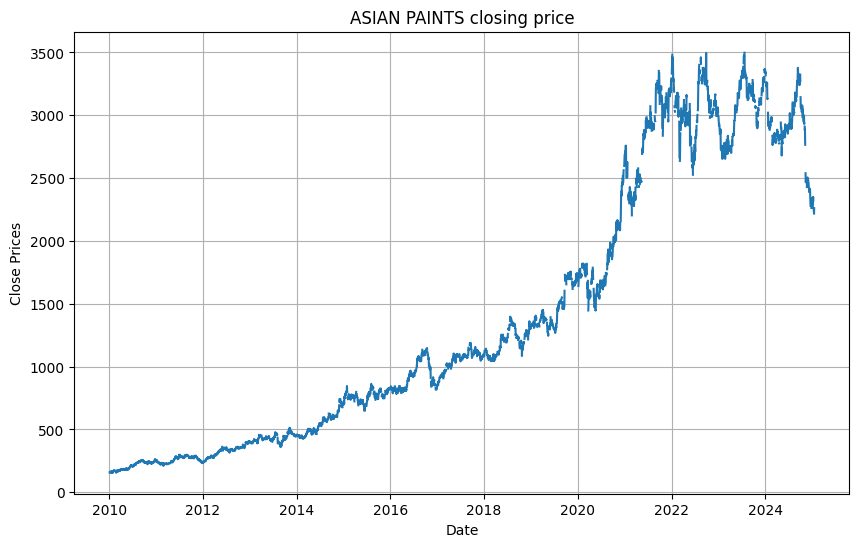

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(pricedata)
plt.title('ASIAN PAINTS closing price')
plt.show()

In [ ]:
# b) Interpolate for Large Gaps (Linear for Smooth Trends)
pricedata1 = pricedata.interpolate(method='linear')

In [ ]:
# a) forward fill
pricedata2 = pricedata.fillna(method='ffill')

<ipython-input-7-c04a5ac1549b>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pricedata2 = pricedata.fillna(method='ffill')


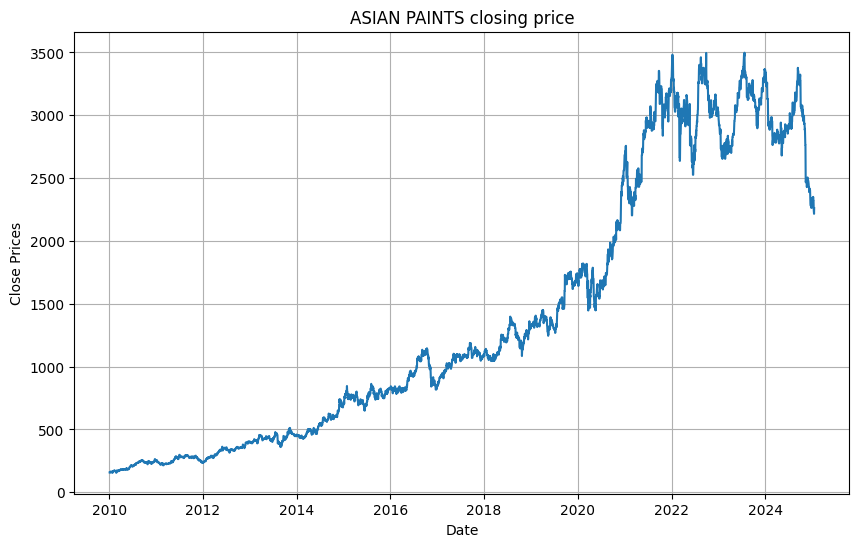

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(pricedata2)
plt.title('ASIAN PAINTS closing price')
plt.show()

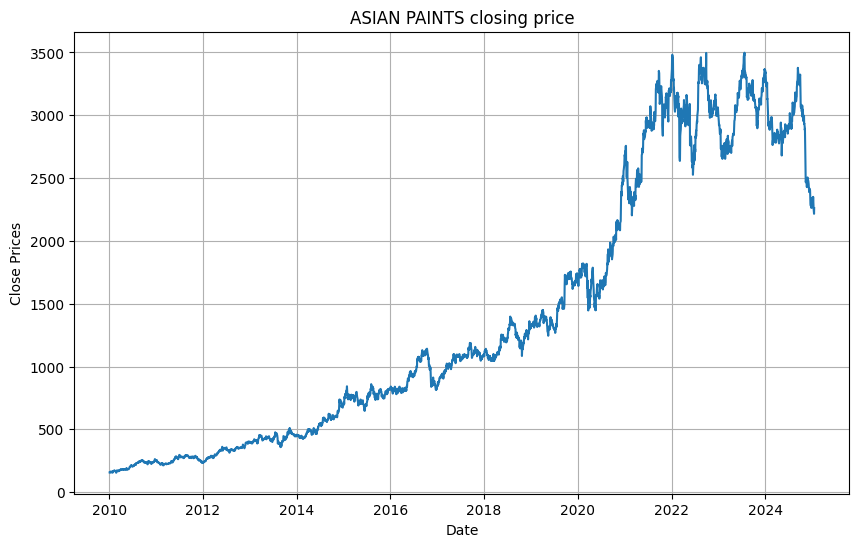

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(pricedata1)
plt.title('ASIAN PAINTS closing price')
plt.show()

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

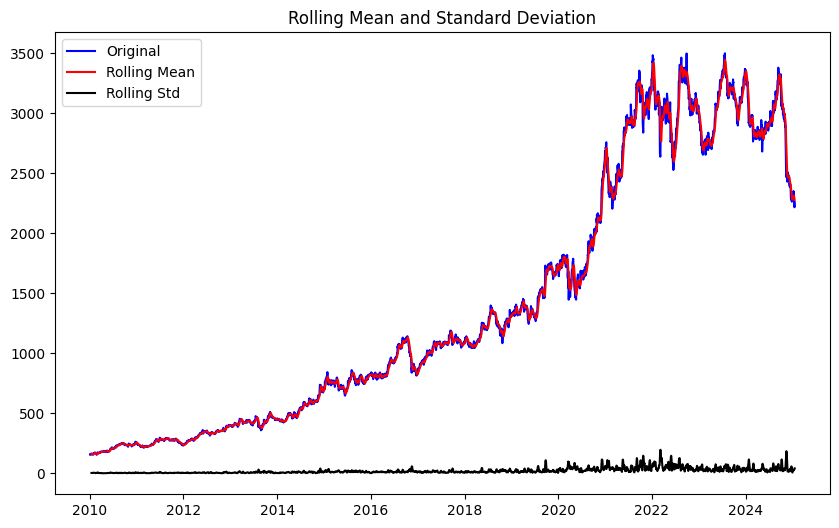

Results of dickey fuller test
Test Statistics                  -0.984391
p-value                           0.758915
No. of lags used                 31.000000
Number of observations used    5461.000000
critical value (1%)              -3.431548
critical value (5%)              -2.862069
critical value (10%)             -2.567052
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):


    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(pricedata1)

#Making our Time Series Stationary

First differencing

In [ ]:
pricedata_diff1 = pricedata.diff()

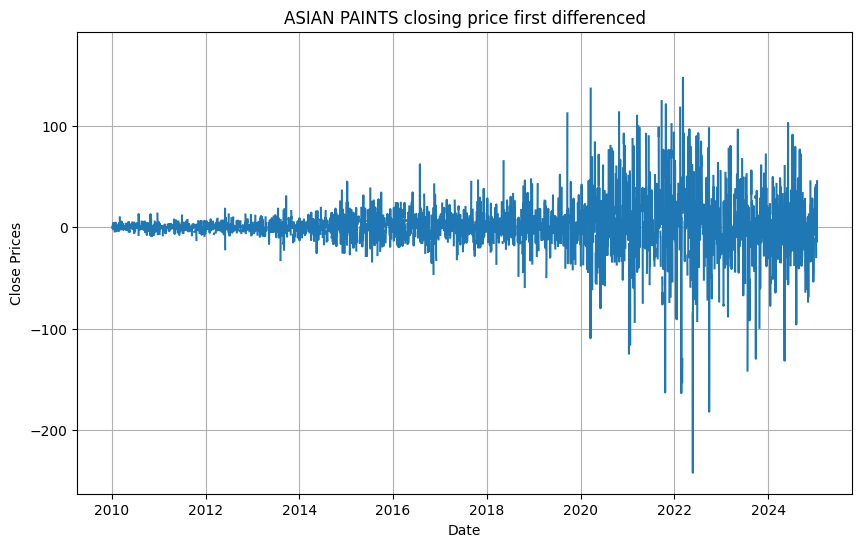

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(pricedata_diff1)
plt.title('ASIAN PAINTS closing price first differenced')
plt.show()

After first differencing, we see that the mean has become somewhat constant but the variance is non constant. So we try log transformation

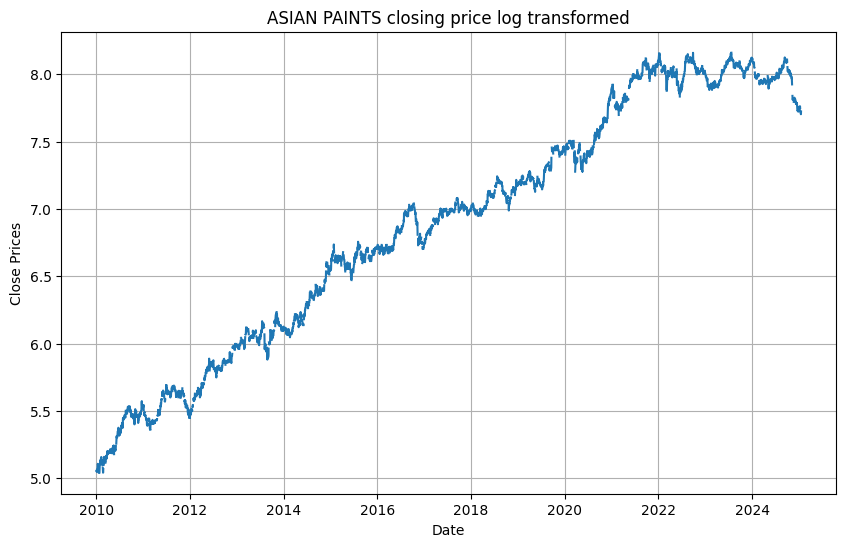

In [ ]:
log_prices = np.log(pricedata)

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(log_prices)
plt.title('ASIAN PAINTS closing price log transformed')
plt.show()

log transformation makes variance constant but now the mean is non constant. So we combine the two.

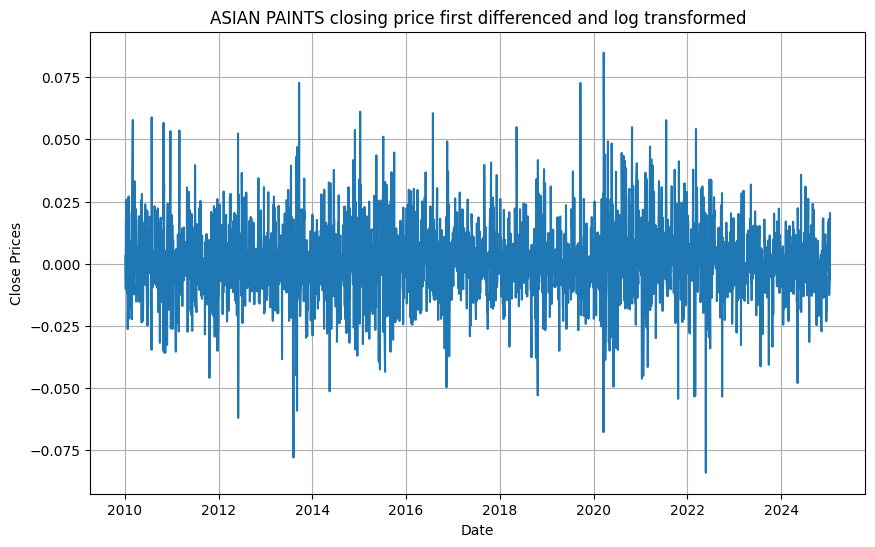

In [ ]:
log_diff = np.log(pricedata).diff()
log_diff = log_diff.dropna() #because differencing turns that first value into nan

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(log_diff)
plt.title('ASIAN PAINTS closing price first differenced and log transformed')
plt.show()


<Figure size 1000x600 with 0 Axes>

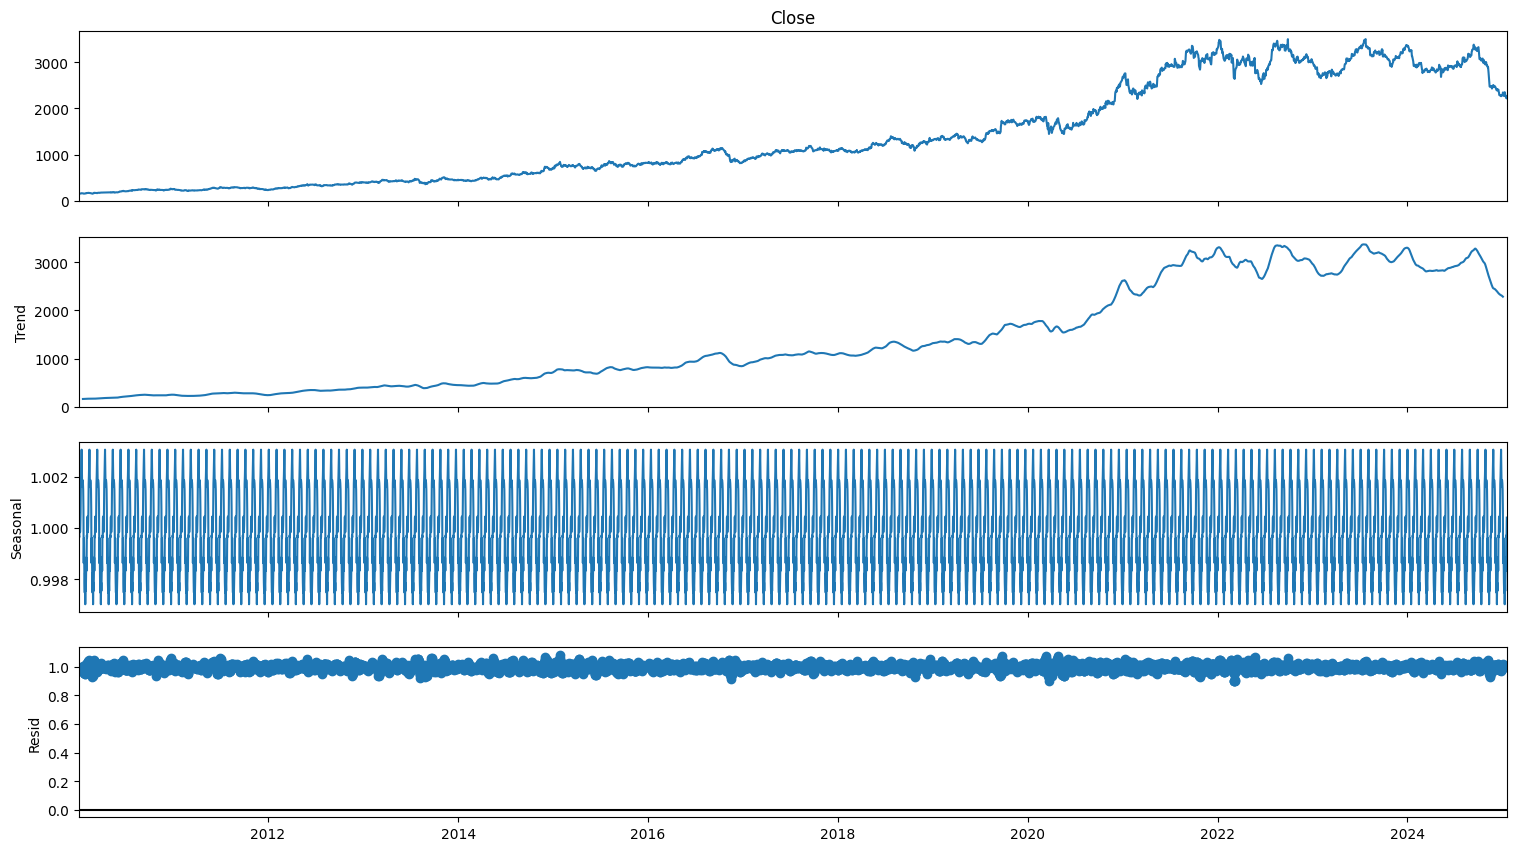

In [ ]:
result = seasonal_decompose(pricedata1, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

<ipython-input-56-32c60ce25e55>:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



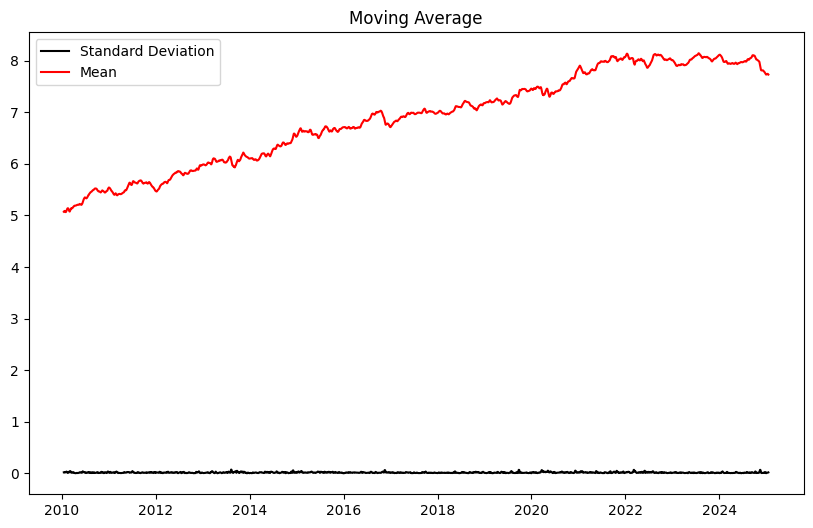

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
logg = np.log(pricedata1)
moving_avg = logg.rolling(12).mean()
std_dev = logg.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Visually, our transformed series looks more stationary compared to the original. The trend is removed, and the variance appears stable. However, to confirm stationarity, we should perform the Augmented Dickey-Fuller (ADF) test again.

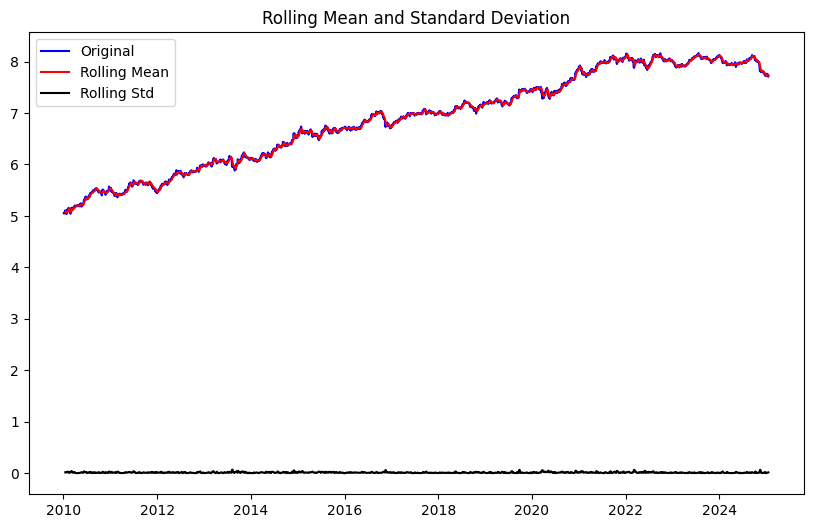

Results of dickey fuller test
Test Statistics                  -2.059849
p-value                           0.260963
No. of lags used                  1.000000
Number of observations used    5491.000000
critical value (1%)              -3.431541
critical value (5%)              -2.862067
critical value (10%)             -2.567050
dtype: float64


In [ ]:
test_stationarity(logg)

Our ADF test results indicate that our time series is now stationary because:

The test statistic (-39.13) is much lower than the critical values (-3.43 at 1% and -2.86 at 5%), meaning we reject the null hypothesis (H₀: series is non-stationary).
The p-value (0.0000) < 0.05, confirming strong evidence for stationarity.

#Model Fitting - ARIMA

In [ ]:
#split data into train and training set

cutoff_test = int(len(logg)*0.95)

y_train = logg.iloc[:cutoff_test]
y_test = logg.iloc[cutoff_test:]

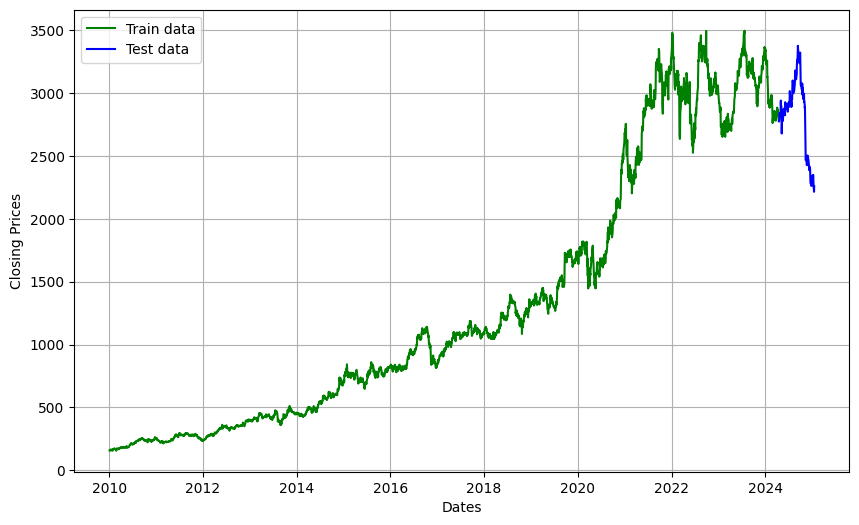

In [ ]:
#visualize the training and test data in the original time series
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(pricedata1.iloc[:int(len(pricedata1)*0.95)], 'green', label='Train data')
plt.plot(pricedata1.iloc[int(len(pricedata1)*0.95):], 'blue', label='Test data')
plt.legend()

In [ ]:
#creating a baseline model

y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 6.83
Baseline MAE: 0.76


Its time to choose parameters p,q,d for ARIMA model by observing the plots of ACF and PACF

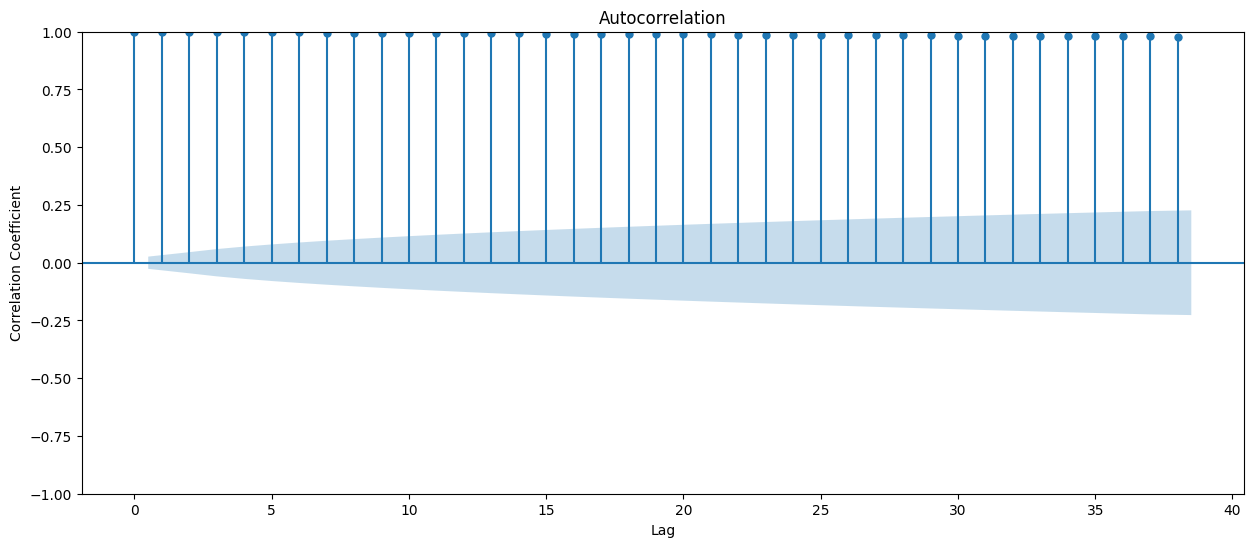

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(logg,ax=ax)

plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient");

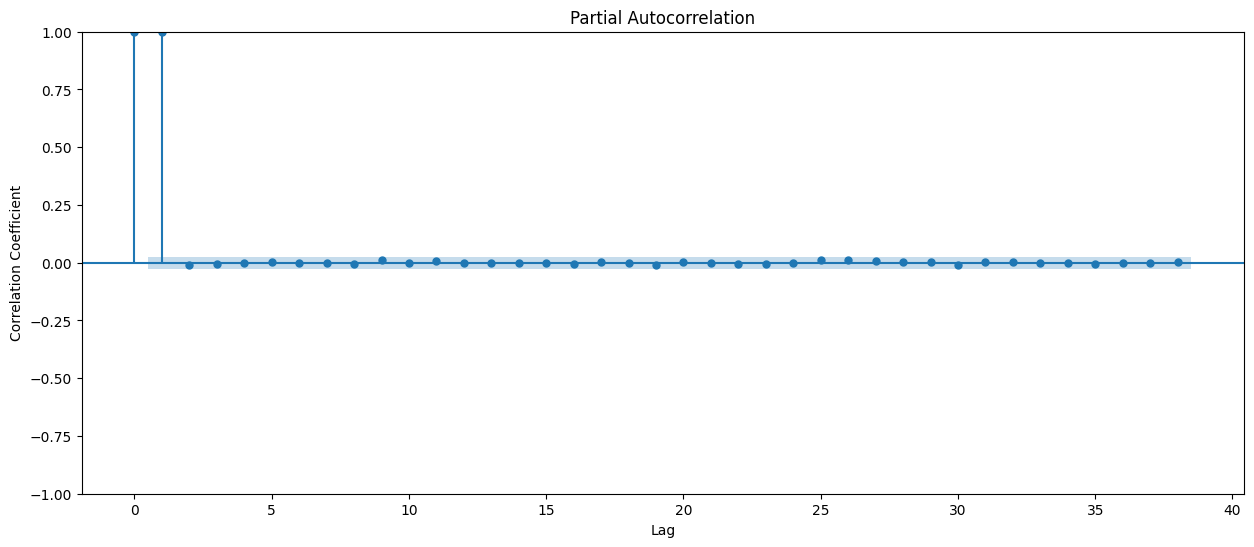

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(logg,ax=ax)
plt.xlabel("Lag")
plt.ylabel("Correlation Coefficient");

Looks like we're fitting an ARMA(1,1) model

In [ ]:

# Build Model
model = ARIMA(y_train, order=(1,1,0)).fit()


In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(1,1,0)).fit()
    next_pred = model.forecast()
    # Use pd.concat to append the next prediction
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]]) # Also updated this line

<ipython-input-61-314e5f79167d>:7: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



In [ ]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.01


In [ ]:
import plotly.express as px
df_predictions = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv})
fig = px.line(df_predictions)
fig.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px

# Fetch more data (Ensure it has a DateTime index)
moredata = get_stock_data(ticker="ASIANPAINT.NS", start_date = datetime(2025,1,20), end_date=datetime(2025,2,1))["Close"]

# Ensure datetime index
moredata.index = pd.to_datetime(moredata.index)

# Initialize variables
y_pred_wfv = pd.Series(dtype="float64")
y_train = logg.copy()
y_test = moredata.copy()
history = y_train.copy()

# Walk-forward validation for test set
for i in range(len(y_test)):
    model = ARIMA(history, order=(1,1,0)).fit()
    next_pred = model.forecast()

    # Append prediction
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred.values, index=[y_test.index[i]])])

    # Update history with actual test value
    history = pd.concat([history, pd.Series(y_test.iloc[i], index=[y_test.index[i]])])

# **Extend Forecasting Beyond Test Set**
N = 12  # Define how many extra steps to forecast (e.g., 12 days)
last_test_date = pd.to_datetime(y_test.index[-1])
future_dates = pd.date_range(start=last_test_date, periods=N+1, freq='D')[1:]

for date in future_dates:
    model = ARIMA(history, order=(1,1,0)).fit()
    next_pred = model.forecast()

    # Append future prediction
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred.values, index=[date])])

    # Update history with the predicted value
    history = pd.concat([history, pd.Series(next_pred.values, index=[date])])

# **Plot the Results**
df_predictions = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv})

fig = px.line(df_predictions, title="ARIMA Walk-Forward Forecast with Extended Predictions")
fig.show()


<ipython-input-68-84a2a20f5d75>:23: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-package

TATA STEEL

In [ ]:
data = get_stock_data("TATASTEEL.NS", datetime(2010,1,20),datetime(2025,2,1))

In [ ]:
pricedata = data["Close"]
pricedata = pricedata.asfreq(pd.infer_freq(pricedata.index))

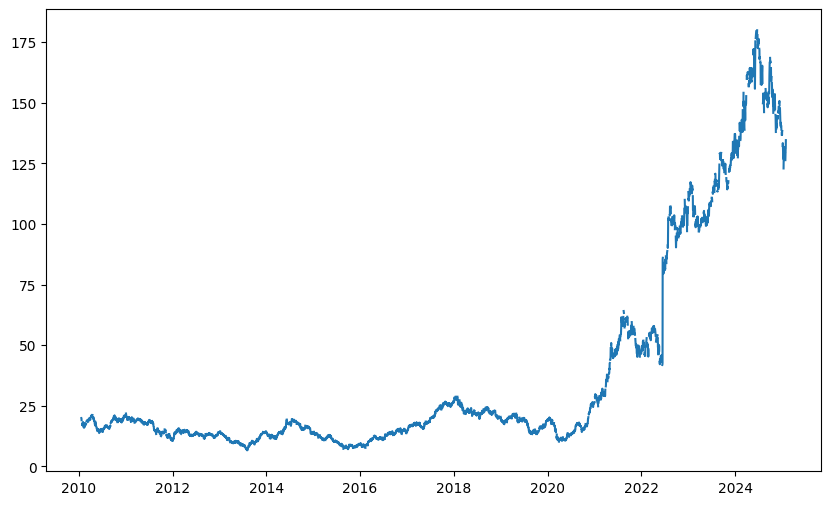

In [ ]:
plt.plot(pricedata)

<Figure size 1000x600 with 0 Axes>

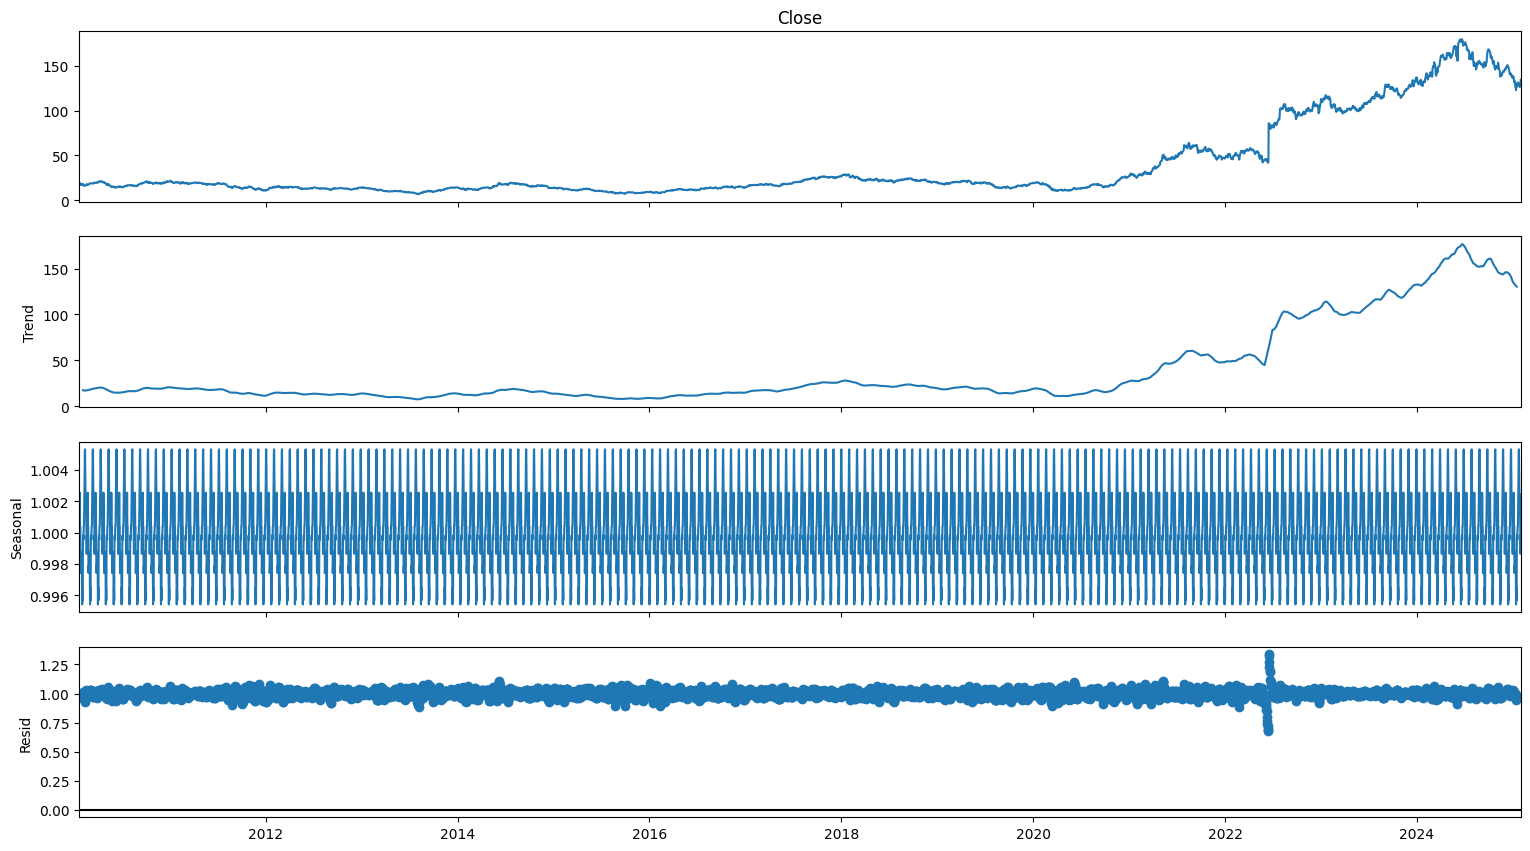

In [ ]:
pricedata1 = pricedata.interpolate(method='linear')
result = seasonal_decompose(pricedata1, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

<ipython-input-89-32c60ce25e55>:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



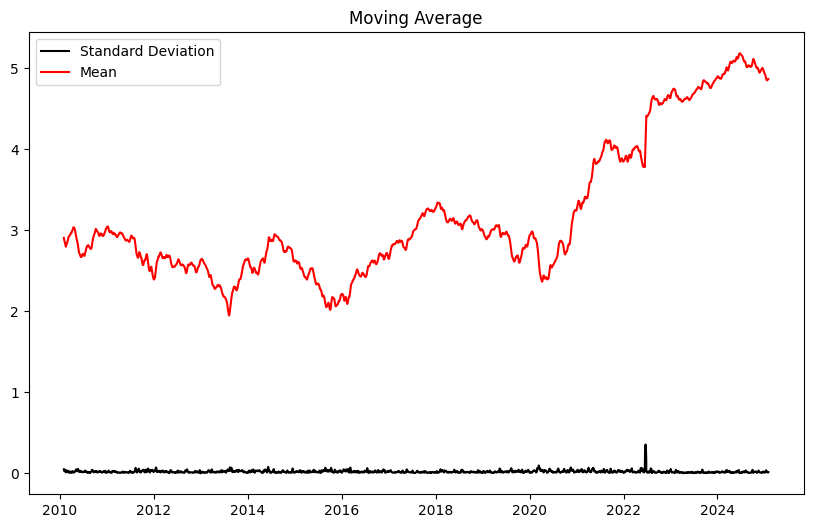

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
logg = np.log(pricedata1)
moving_avg = logg.rolling(12).mean()
std_dev = logg.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

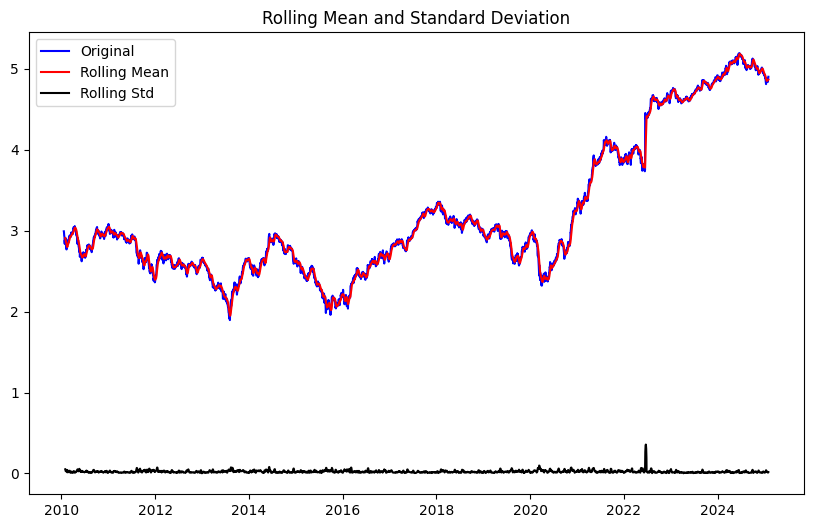

Results of dickey fuller test
Test Statistics                   0.182796
p-value                           0.971280
No. of lags used                  2.000000
Number of observations used    5488.000000
critical value (1%)              -3.431542
critical value (5%)              -2.862067
critical value (10%)             -2.567050
dtype: float64


In [ ]:
test_stationarity(logg)

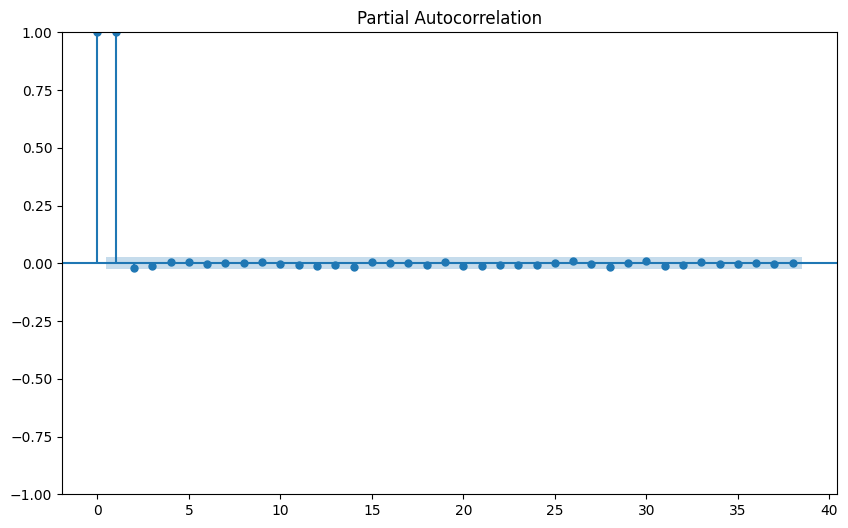

In [ ]:
plot_pacf(logg)
plt.show()

In [ ]:
model = ARIMA(logg, order=(1,1,0)).fit()
y_pred_wfv = pd.Series()
history = logg.copy()
for i in range(len(logg)):
    model = ARIMA(history, order=(1,1,0)).fit()
    next_pred = model.forecast()

In [ ]:
import plotly.express as px
df_predictions = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv})
fig = px.line(df_predictions)
fig.show()

#VOLATILITY PREDICTION


In [ ]:
returns = 100*pricedata1.pct_change().dropna()

Text(0.5, 1.0, 'stock Returns')

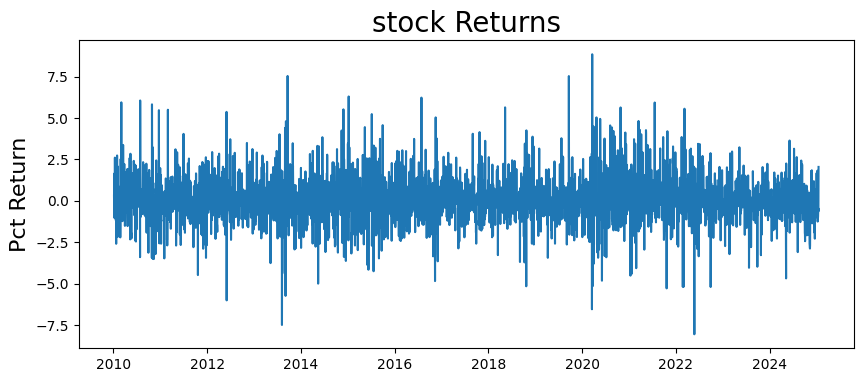

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('stock Returns', fontsize=20)

Text(0.5, 1.0, 'stock Returns')

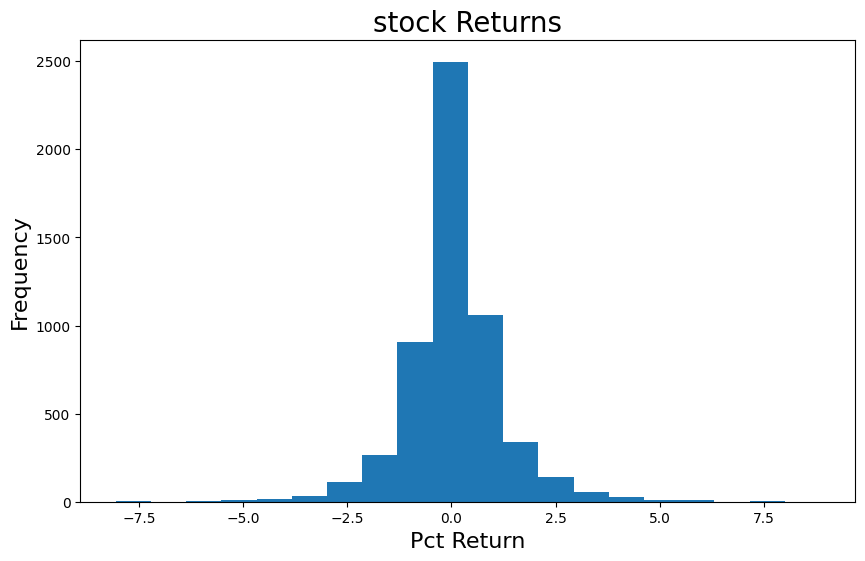

In [ ]:
plt.hist(returns, bins=20)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Pct Return', fontsize=16)
plt.title('stock Returns', fontsize=20)

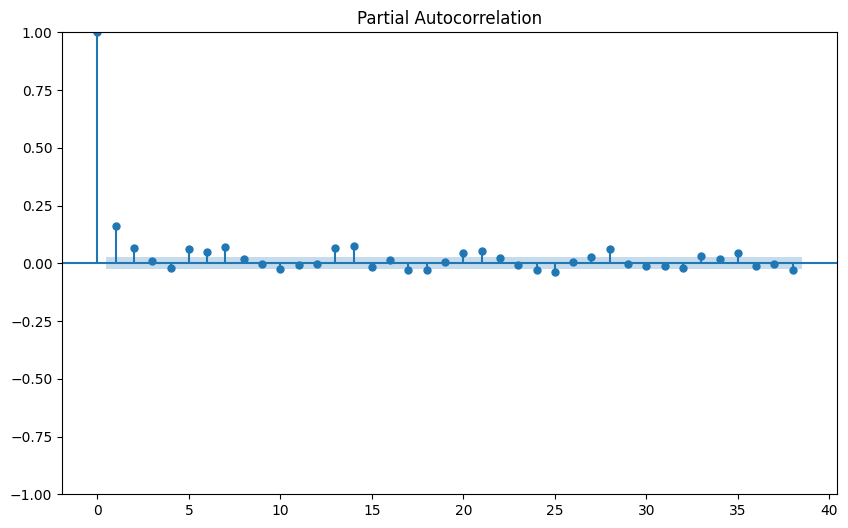

In [ ]:
plot_pacf(returns**2)
plt.show()

In [ ]:
cutoff_test = int(0.8*len(returns))
r_train = returns.iloc[:cutoff_test]

In [ ]:
model = arch_model(r_train, p=1, q=1)
model_fit = model.fit()
model_fit.summary()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 169502.52546130324
Iteration:      2,   Func. Count:     15,   Neg. LLF: 13982.329420536156
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7063.842700949378
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6897.325246918676
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6898.373850780294
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6900.798643525638
Iteration:      7,   Func. Count:     46,   Neg. LLF: 6891.6229163871685
Iteration:      8,   Func. Count:     51,   Neg. LLF: 6891.59442496486
Iteration:      9,   Func. Count:     56,   Neg. LLF: 6891.593975012513
Iteration:     10,   Func. Count:     61,   Neg. LLF: 6891.59392659189
Iteration:     11,   Func. Count:     65,   Neg. LLF: 6891.5939265920015
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6891.59392659189
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6891.59
Distribution:                  Normal   AIC:                           13791.2
Method:            Maximum Likelihood   BIC:                           13816.7
                                        No. Observations:                 4393
Date:                Sun, Feb 02 2025   Df Residuals:                     4392
Time:                        12:34:47   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0826  1.859e-02      4.442  8.927e-06 [4.613e-02,  0.119]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9907  9.627e-02     10.290  7.808e-25    [  0.802,  1.179]
alpha[1]       0.2616  4.630e-02      5.650  1.603e-08    [  0.171,  0.352]
beta[1]        0.0759  6.798e-02      1.116      0.264 [-5.738e-02,  0.209]
===========================================================================

Covariance estimator: robust
"""

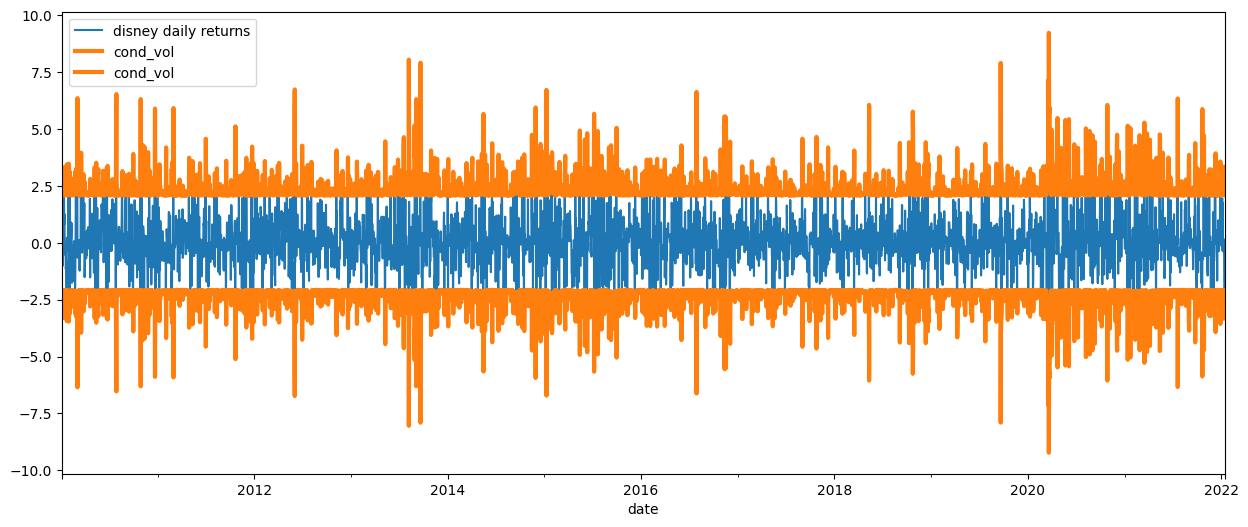

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

r_train.plot(ax=ax,label = "disney daily returns")

# Plot conditional volatility * 2
(2*model_fit.conditional_volatility).plot(
    ax=ax,
    color="C1",
    linewidth = 3
)


# Plot conditional volatility * -2
(-2*model_fit.conditional_volatility).plot(
    ax=ax,
    color="C1",
    linewidth = 3
)


# Add axis labels

plt.xlabel("date")

# Add legend
plt.legend()


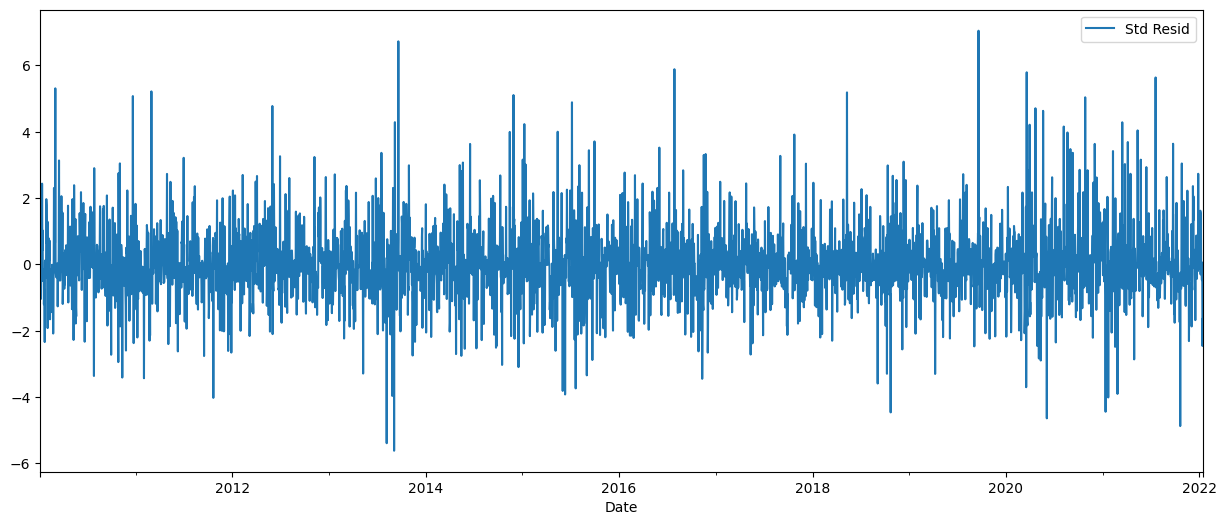

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals

model_fit.std_resid.plot(ax=ax, label = "Std Resid")
# Add axis labels



# Add legend
plt.legend()


(array([   2.,    2.,    2.,    8.,   10.,   19.,   63.,   94.,  209.,
         546., 1261., 1173.,  510.,  235.,  110.,   62.,   34.,   22.,
          10.,    6.,    4.,    6.,    3.,    0.,    2.]),
 array([-5.61813131, -5.11156717, -4.60500303, -4.09843889, -3.59187474,
        -3.0853106 , -2.57874646, -2.07218232, -1.56561818, -1.05905403,
        -0.55248989, -0.04592575,  0.46063839,  0.96720253,  1.47376668,
         1.98033082,  2.48689496,  2.9934591 ,  3.50002324,  4.00658739,
         4.51315153,  5.01971567,  5.52627981,  6.03284395,  6.5394081 ,
         7.04597224]),
 <BarContainer object of 25 artists>)

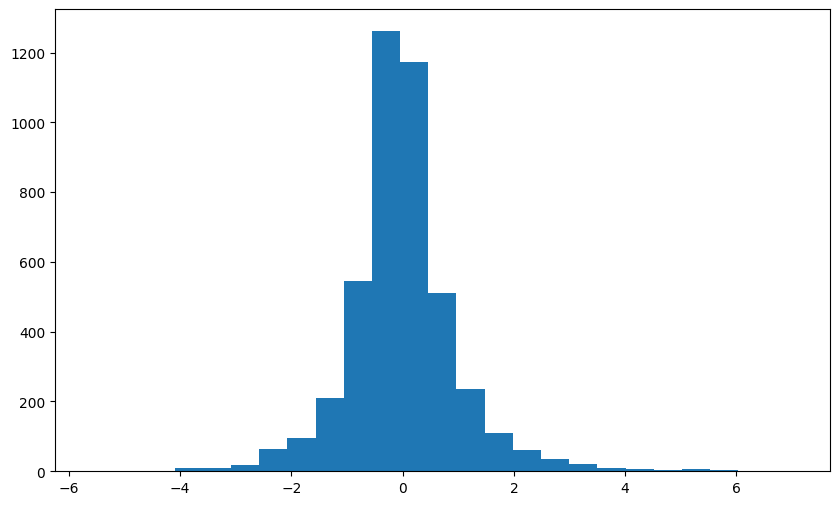

In [ ]:
plt.hist(model_fit.std_resid,bins=25)


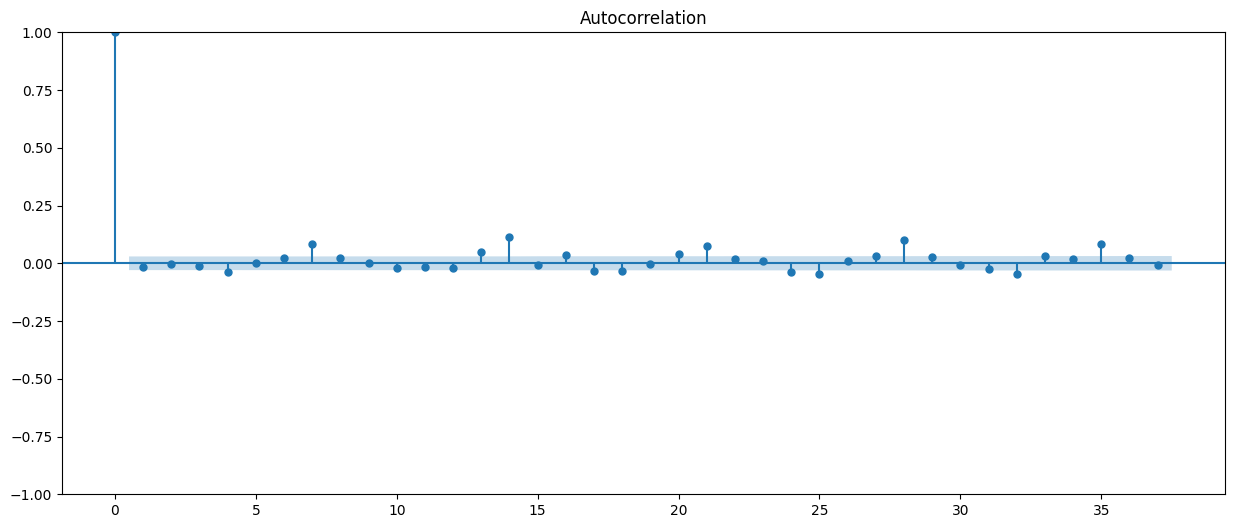

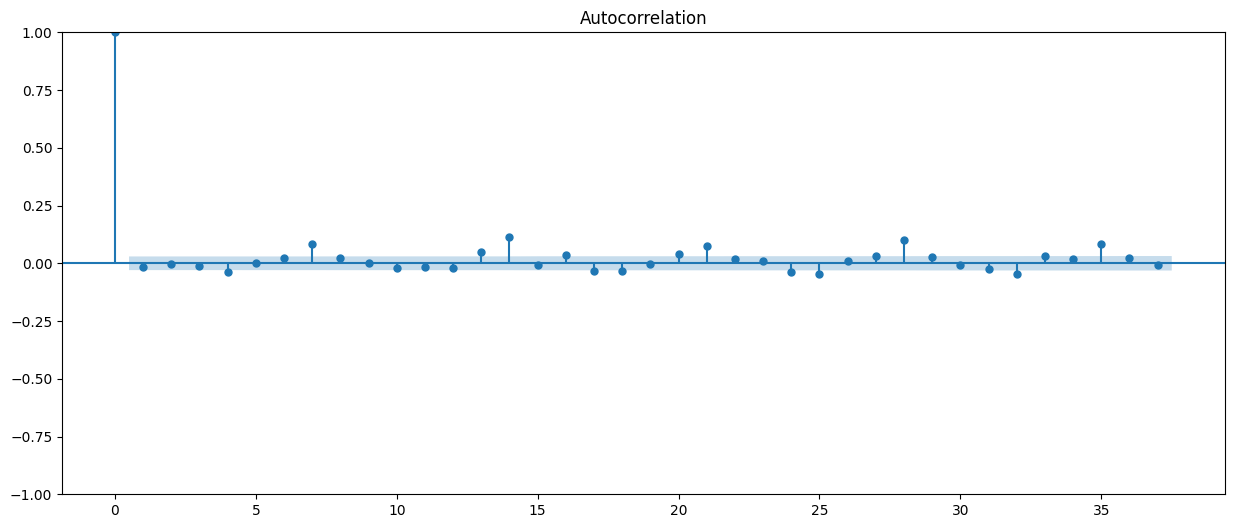

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals

plot_acf(model_fit.std_resid**2,ax=ax)
# Add axis labels

In [ ]:
rolling_predictions = []
test_size = int(len(returns) * 0.2)

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_predictions = pd.Series(rolling_predictions, index=returns.tail(test_size).index)

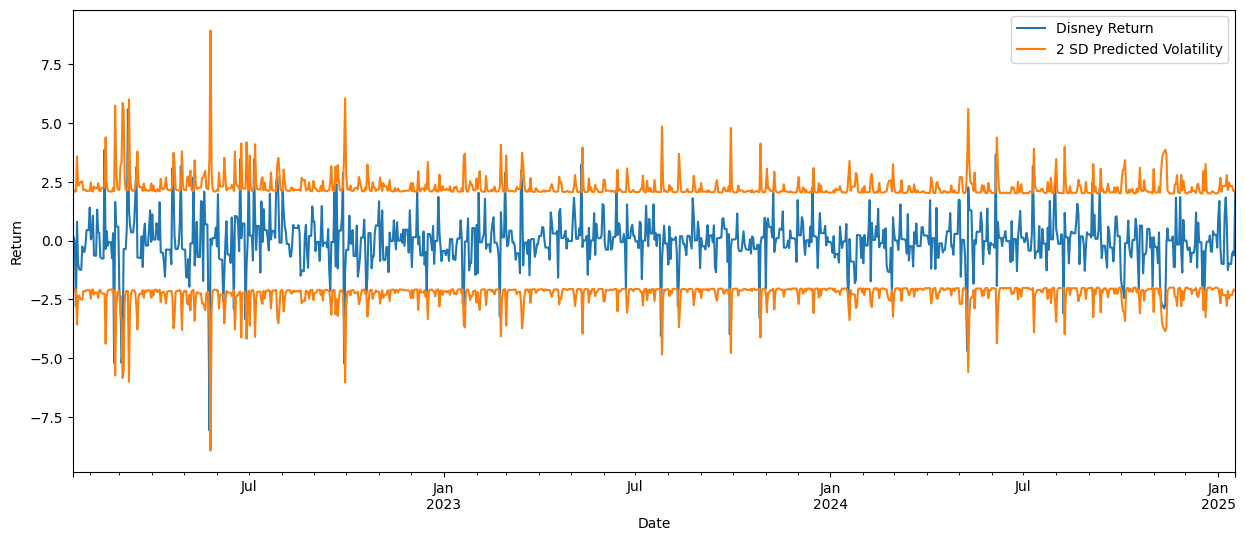

In [ ]:
gig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
returns.tail(test_size).plot(ax=ax, label="Disney Return")

# Plot volatility predictions * 2
(2 * rolling_predictions).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * rolling_predictions).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();



Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

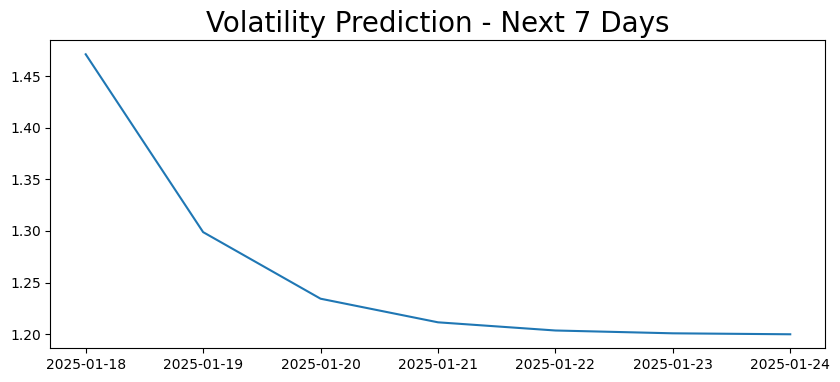

In [ ]:
train = returns
model = arch_model(train, p=1, q=2)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)